<a href="https://colab.research.google.com/github/hansong0219/Advanced-DeepLearning-Study/blob/master/auto_encoder/DAE_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

잡음제거 오토인코더
--------

잡음 제거 오토 인코더는 오토 인코더의 잠재 벡터에서 원본 사진으로의 변환 과정과 동일한 구조를 갖는다. 다만 인코더의 입력을 잡음으로 인하 훼손된 원본 사진으로 규정의하고, 출력을 원본 사진으로 정의한다. 이때 디코더가 원본의 차이 손실함수인 MSE 를 최소화 하는 방향으로 복원하는 것을 목표로한다. 

In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
np.random.seed(1337) # 이미지 훼손을 위한 random.seed

데이터 처리
-------

In [3]:
#데이터 로딩
(x_train, _),(x_test,_) = mnist.load_data()

In [4]:
#형상을 변경하고 입력 이미지 정규화
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [5]:
# 평균 0.5, std 0.5 의 정규분포를 따르는 잡음을 추가하여 훼손된 이미지를 생성한다.
noise = np.random.normal(loc=0.5,scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5,scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

#잠음 추가시 정규화된 픽셀의 값이 1보다 커지거나 0 보다 작아 질 수 있다. 따라서 이를 고정시킨다.

x_train_noisy = np.clip(x_train_noisy, 0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)

모델 구성
------

In [6]:
#모델 구성을 위해 네트워크 매개변수를 지정한다.
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16

#CNN 계층의 인코더/디코더 개수 구성
layer_filters = [32,64]

In [11]:
# 인코더 구성 
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Conv2D(32) - Conv2D(64) 스택
for filters in layer_filters:
  x =Conv2D(filters=filters,
            kernel_size = kernel_size,
            strides =2,
            activation ='relu',
            padding='same')(x)
  
#디코더 모델 구성을 위한 정보 획득 
shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim,name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')

In [12]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 디코더 모델 구성
latent_inputs = Input(shape=(latent_dim,),name='decoder_input')

# 저장된 shape 변수 이용
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
# 전치 벡터에 적합한 형상으로 변환
x = Reshape((shape[1],shape[2],shape[3]))(x)

#Conv2DTranspose 스택 
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters = filters,
                      kernel_size = kernel_size,
                      strides = 2,
                      activation = 'relu',
                      padding = 'same')(x)

# 잡음 제거 입력 재구성
outputs = Conv2DTranspose(filters = 1,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation='sigmoid',
                          name = 'decoder_output')(x)

#디코더 모델 인스턴스화
decoder = Model(latent_inputs,outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [16]:
# 오토 인코더 모델 구성 
autoencoder = Model(inputs,decoder(encoder(inputs)),name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [17]:
# MSE 손실함수와 Adam optimizer 를 이용한 모델 컴파일
autoencoder.compile(loss='mse',optimizer='adam')

In [18]:
autoencoder.fit(x_train_noisy, x_train, validation_data = (x_test_noisy, x_test),epochs=10, batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0367 - val_loss: 0.0205
Epoch 2/10
1875/1875 [==============================] - 105s 56ms/step - loss: 0.0193 - val_loss: 0.0179
Epoch 3/10
1875/1875 [==============================] - 105s 56ms/step - loss: 0.0176 - val_loss: 0.0170
Epoch 4/10
1875/1875 [==============================] - 105s 56ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 5/10
1875/1875 [==============================] - 106s 56ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 6/10
1875/1875 [==============================] - 106s 57ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 7/10
1875/1875 [==============================] - 106s 56ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 8/10
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 9/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.0152 - val_loss: 0.0156
Epoch 10/10
1875/1875 [==============================] 

모델 출력 예측
------

In [19]:
#훼손된 테스트 이미지를 이용한 오토인코더 출력예측
x_decoded = autoencoder.predict(x_test_noisy)

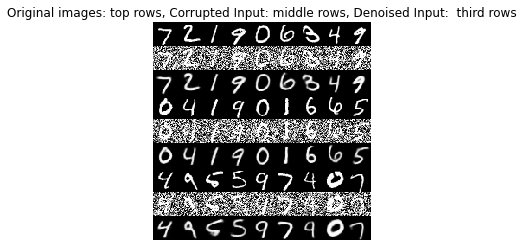

In [20]:
# 이미지 Plot
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()